In [1]:
import hashlib
import os
import tarfile
import zipfile
import requests

#@save
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

In [2]:
def download(name, cache_dir=os.path.join('..','data')): #@save
    """下载一个DATA_HUB中的文件，返回本地文件名"""
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}"
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            #计算文件的hash值
            while True:
                # 1048576=1MB 每次读取1MB
                data = f.read(1048576)
                # 如果文件读完了，就退出循环
                if not data:
                    break
                # 更新hash值
                sha1.update(data)
        # 获取hash值的十六进制表示
        if sha1.hexdigest() == sha1_hash:
            return fname
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    # print(fname)
    return fname

In [3]:
def download_extract(name, folder=None): #@save
    """下载并解压zip/tar文件"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname,'r')
    elif ext in('.tar','.gz'):
        fp = tarfile.open(fname,'r')
    else:
        assert False, '只有zip/tar文件可以被解压缩'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all(): #@save
    """下载DATA_HUB中的所有文件"""
    for name in DATA_HUB:
        download(name)

In [4]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

In [5]:
DATA_HUB['kaggle_house_train'] = (  #@save
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (  #@save
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

In [6]:
train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

In [7]:
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


In [8]:
print(train_data.iloc[[0,1,2,3,-4,-3,-2,-2,-1], [0,1,2,3,4,5,-2,-1]])

        Id  MSSubClass MSZoning  LotFrontage  LotArea Street SaleCondition  \
0        1          60       RL         65.0     8450   Pave        Normal   
1        2          20       RL         80.0     9600   Pave        Normal   
2        3          60       RL         68.0    11250   Pave        Normal   
3        4          70       RL         60.0     9550   Pave       Abnorml   
1456  1457          20       RL         85.0    13175   Pave        Normal   
1457  1458          70       RL         66.0     9042   Pave        Normal   
1458  1459          20       RL         68.0     9717   Pave        Normal   
1458  1459          20       RL         68.0     9717   Pave        Normal   
1459  1460          20       RL         75.0     9937   Pave        Normal   

      SalePrice  
0        208500  
1        181500  
2        223500  
3        140000  
1456     210000  
1457     266500  
1458     142125  
1458     142125  
1459     147500  


In [9]:
all_features = pd.concat((train_data.iloc[:,1:-1],test_data.iloc[:,1:]))

In [10]:
#获取数值特征列的索引
numeric_features = all_features.dtypes[all_features.dtypes!='object'].index
#按列对数值特征标准化:使特征值的均值为0，方差为单位方差
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x:(x-x.mean())/(x.std()))
#将缺失值替换为0（均值）
all_features[numeric_features] = all_features[numeric_features].fillna(0)

In [11]:
#将离散值转换为独热编码，如果某1列有n种离散值，就会新创建n列来替换原来的1列
# dummy_na=True将缺失值也当作合法的特征值并为其创建指示特征
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape #可以看到数值特征的个数从79增加到了331

(2919, 331)

In [12]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(train_data.SalePrice.values.reshape(-1,1),dtype=torch.float32)

In [13]:
# 定义损失为均方损失
loss = nn.MSELoss()
in_features = train_features.shape[1]

def get_net():
    net = nn.Sequential(nn.Linear(in_features,1))
    return net

In [14]:
df = pd.DataFrame({
    'color':['red','green','blue','black','red'],
})
df_dummies = pd.get_dummies(df)
df,df_dummies

(   color
 0    red
 1  green
 2   blue
 3  black
 4    red,
    color_black  color_blue  color_green  color_red
 0            0           0            0          1
 1            0           0            1          0
 2            0           1            0          0
 3            1           0            0          0
 4            0           0            0          1)

log_rmse 函数计算的是均方根误差（RMSE）的对数，这是一个常用的回归问题的评估指标  
相较于绝对误差y-y_hat，更关心相对误差(y-y_hat)/y，所以使用对数来计算  
log_rmse是模型的评估指标，而不是损失函数！  
为什么不能成为损失函数：clamp函数的导数在1处不可导  

In [15]:

def log_rmse(net, features, labels):
    #限制预测值大于等于1
    clipped_preds = torch.clamp(net(features),1,float('inf'))
    #定义误差计算方法为对数均方根误差
    rmse = torch.sqrt(loss(torch.log(clipped_preds),torch.log(labels)))
    return rmse.item()

In [16]:
def train(net, train_features, train_labels, test_features, test_labels, 
          num_epochs, learning_rate, weight_decay, batch_size):
      train_ls, test_ls = [],[]
      train_iter = d2l.load_array((train_features, train_labels),batch_size)
      # 使用Adam优化算法
      optimizer = torch.optim.Adam(net.parameters(), 
                                    lr=learning_rate,
                                    weight_decay=weight_decay)
      for epoch in range(num_epochs):
            for X,y in train_iter:
                  optimizer.zero_grad()
                  l=loss(net(X),y)
                  l.backward()
                  optimizer.step()
            # 用于存储每个训练周期（epoch）结束时的训练误差
            train_ls.append(log_rmse(net, train_features, train_labels))
            # 训练的时候是没有测试集的，K折交叉验证的时候有测试集
            if test_labels is not None:
                  # 用于存储每个训练周期（epoch）结束时的测试误差
                  test_ls.append(log_rmse(net, test_features, test_labels))
      return train_ls, test_ls

如果训练数据不够大，我们会使用K折交叉验证来进行模型选择   
K折交叉验证只是进行模型原则，不是模型训练！！  
通过将数据集分为K个子集（或“折叠”），模型可以分别在K-1个折叠上训练，并在剩余的一个折叠上测试。这个过程重复K次，每次选择不同的折叠作为测试集，其余作为训练集。这样，模型会被多次训练和验证，每个数据点都被用作训练和验证，从而提供了一个全面的评估。

In [17]:
def get_k_folder_data(k,i,X,y):
    assert k>1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        # slice函数返回切片对象，slice(start,stop,step)
        idx = slice(j*fold_size, (j+1)*fold_size)
        # 获得第j个分区的数据
        X_part, y_part = X[idx,:],y[idx]
        if j==i:
            # 第i个分区作为验证数据集
            X_valid,y_valid = X_part,y_part
        elif X_train is None:
            X_train,y_train = X_part,y_part
        else:
            # 将其他非i分区的数据拼接起来
            X_train = torch.cat([X_train, X_part],0)
            y_train = torch.cat([y_train, y_part],0)
    # 返回k-1个分区的训练数据集和1个分区的验证数据集
    return X_train, y_train, X_valid, y_valid

In [18]:
# 训练次数为k*epochs，每次训练都会使用不同的验证数据集
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0,0
    for i in range(k):
        # 注意这里的data包含4个元素的列表
        data = get_k_folder_data(k,i,X_train,y_train)
        # 每一折都会初始化一个新的网络，网络之间不共享参数
        net = get_net()
        # 星号 * 是一个特殊的语法，用于在函数调用时解包参数列表
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate, weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1,num_epochs+1)), [train_ls, valid_ls],
                     xlabel='epoch',ylabel='rmse',xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'折{i+1},训练log rmse{float(train_ls[-1]):f},'
              f'验证log_rmse{float(valid_ls[-1]):f}')
    return train_l_sum/k, valid_l_sum/k

折1,训练log rmse0.172226,验证log_rmse0.156136
折2,训练log rmse0.164442,验证log_rmse0.188142
折3,训练log rmse0.166518,验证log_rmse0.173060
折4,训练log rmse0.170424,验证log_rmse0.155837
折5,训练log rmse0.165076,验证log_rmse0.183555
5-折验证：平均训练log rmse:0.167737,平均验证log rmse:0.171346


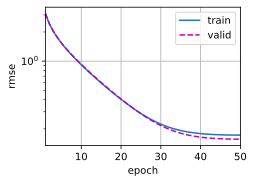

In [19]:
k,num_epochs, lr, weight_decay, batch_size = 5, 50, 5, 0, 32
# 注意，K折交叉验证时是没有测试集参与的
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)
print(f'{k}-折验证：平均训练log rmse:{float(train_l):f},'
      f'平均验证log rmse:{float(valid_l):f}')

In [20]:
def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls,_=train(net, train_features, train_labels, None, None, 
                     num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs+1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1,num_epochs], yscale='log')
    print(f'训练log rmse:{float(train_ls[-1]):f}')
    # 将网络应用于测试集
    # detach()返回一个新的tensor，从当前计算图中分离下来的
    # 这个张量仍指向原变量的存放位置，但不会保存原张量的梯度
    preds = net(test_features).detach().numpy()
    # 将其重新格式化以导出到Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1,-1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index = False)

训练log rmse:0.167102


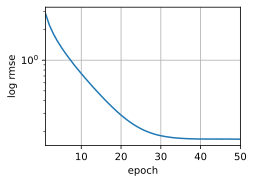

In [21]:
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)

In [22]:
tmp = np.arange(12).reshape(3,4)
tmp1 = tmp.reshape(1,-1)[0]
tmp2 = tmp.reshape(-1,1)[:,0]
print(tmp1)
print(tmp2)

[ 0  1  2  3  4  5  6  7  8  9 10 11]
[ 0  1  2  3  4  5  6  7  8  9 10 11]
